1. Move SNN to an external file/library.
2. Add SNN parameters to pickle file

In [75]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torch.utils.data.sampler import SubsetRandomSampler

In [76]:
# class SNN(nn.Module):
    
#     def __init__(self, input_size, hidden_size, output_size, afcn):
#         super(SNN, self).__init__()
        
#         self.afcn = afcn
        
#         # fc -> fully connected
#         self.fc1 = nn.Linear(input_size, hidden_size)
        
#         if afcn == 'ReLu':
#             self.squash = nn.ReLU()
#         elif afcn == 'Sigmoid':
#             self.squash = nn.Sigmoid()
#         elif afcn == 'Tanh':
#             self.squash = nn.Tanh()
#         else:
#             print('ERROR: invalid activation function', afcn)
        
#         self.fc2 = nn.Linear(hidden_size, output_size)
        
#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.squash(out)
#         out = self.fc2(out)
#         return out
class SNN(nn.Module):
    
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SNN, self).__init__()
        
        self.afcn = 'ReLu'
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        
        if afcn == 'ReLu':
            self.squash = nn.ReLU()
        elif afcn == 'Sigmoid':
            self.squash = nn.Sigmoid()
        elif afcn == 'Tanh':
            self.squash = nn.Tanh()
        else:
            print('ERROR: invalid activation function', afcn)
        
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.squash(self.fc1(x))
        out = self.squash(self.fc2(out))
        out = self.fc3(out)
        return out

In [77]:
# Network parameters
net_file = 'network-parameters.pickle'
with open(net_file, 'rb') as pickle_file:
    net_params = pickle.load(pickle_file)

input_size = net_params['input_size']
output_size = net_params['output_size']
hidden_size = net_params['hidden_size']
activation_fcn = net_params['activation_fcn']

# Neural networks
dlon_model = SNN(input_size, hidden_size, output_size, activation_fcn)
dlon_model.load_state_dict(torch.load('models/dlon.ckpt'))
dlon_model.eval()

dlat_model = SNN(input_size, hidden_size, output_size, activation_fcn)
dlat_model.load_state_dict(torch.load('models/dlat.ckpt'))
dlat_model.eval()

dyaw_model = SNN(input_size, hidden_size, output_size, activation_fcn)
dyaw_model.load_state_dict(torch.load('models/dyaw.ckpt'))
dyaw_model.eval()

print('Models loaded and in evaluation mode.')

Models loaded and in evaluation mode.


In [80]:
# Simulate the UGV

dist = 50 * 0.01
targets = [
    (  dist,     0 ),
    (     0,  dist ),
    (  dist,  dist ),
    ( -dist,  dist ),
    (     0, -dist ),
    ( -dist, -dist ),
    ( -dist,     0 ),
    (  dist, -dist ),
    (     0,     0 ),
]

dlons = []
dlats = []
dyaws = []

with torch.no_grad():
    
    # Control
    left = 1
    right = -7
    strut = 0.015
    
    # From fsm.cpp (PRINT_STEP)
    time_step_ms = 1000
    time_ms = 0
    time_stop_ms = 1 * 1000
    
    while time_ms < time_stop_ms:
        time_ms += time_step_ms

        # Setup control input
        u = torch.tensor([left, right, strut])
        
        # Simulate UGV
        dlon = dlon_model(u)
        dlat = dlat_model(u)
        dyaw = dyaw_model(u)
        
        # Save results
        dlons.append(dlon.item())
        dlats.append(dlat.item())
        dyaws.append(dyaw.item())

df = pd.DataFrame({
    'dlon': dlons,
    'dlat': dlats,
    'dyaw': dyaws,
    'time': np.linspace(0, 60, len(dlons))
})

In [81]:
df

,dlon,dlat,dyaw,time
0,0.017532,-0.025696,0.374217,0.0


/Users/ajc/miniconda3/envs/deeplearning/lib/python3.7/site-packages/pandas/plotting/_core.py:998: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)
/Users/ajc/miniconda3/envs/deeplearning/lib/python3.7/site-packages/pandas/plotting/_core.py:998: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)
/Users/ajc/miniconda3/envs/deeplearning/lib/python3.7/site-packages/pandas/plotting/_core.py:998: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


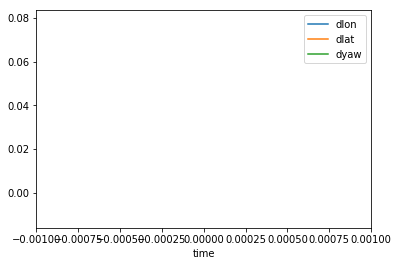

In [60]:
df.set_index('time').plot();

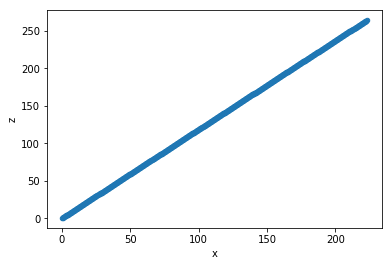

In [19]:
df.plot.scatter('x', 'z')

In [40]:
with torch.no_grad():

    left_speeds = np.linspace(-4, 4, 100)
    right_speeds = np.linspace(0, 4, 100)
    
    dlons = []
    dlats = []
    
    for ls, rs in zip(left_speeds, right_speeds):
        
        u = torch.tensor([ls, rs, 0.001])
        dlon = dlon_model(u)
        dlat = dlat_model(u)
        
        dlons.append(dlon.item())
        dlats.append(dlat.item())

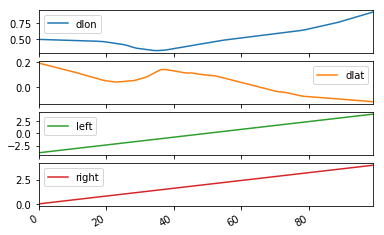

In [43]:
df = pd.DataFrame({
    'dlon': dlons,
    'dlat': dlats,
    'left': left_speeds,
    'right': right_speeds
})

df.plot(subplots=True);

In [44]:
df

,dlon,dlat,left,right
0,0.500400,0.195446,-4.000000,0.000000
1,0.498781,0.188418,-3.919192,0.040404
2,0.497162,0.181391,-3.838384,0.080808
3,0.495543,0.174363,-3.757576,0.121212
4,0.493924,0.167335,-3.676768,0.161616
5,0.492305,0.160307,-3.595960,0.202020
6,0.490686,0.153279,-3.515152,0.242424
7,0.489067,0.146251,-3.434343,0.282828
8,0.487448,0.139223,-3.353535,0.323232
9,0.485829,0.132196,-3.272727,0.363636
